# Loading Libraraires

In [55]:
import argparse
import logging
import seaborn as sns
import sys
import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'
from tqdm.notebook import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error,r2_score, mean_absolute_error
import json
from timeit import default_timer as timer
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.gridspec as gridspec
from configparser import ConfigParser
import torch
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from disvae import init_specific_model, Trainer, Evaluator
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import LOSSES, RECON_DIST, get_loss_f
from disvae.models.vae import MODELS
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from utils.helpers import (create_safe_directory, get_device, set_seed, get_n_param,
                           get_config_section, update_namespace_, FormatterNoDuplicate)
from utils.visualize import GifTraversalsTraining
import os
from torch.utils.data import DataLoader
from utils.datasets import DSprites
import pandas as pd
from disvae.utils.modelIO import load_model, load_metadata
logger = logging.getLogger(__name__)
dim,thresh=1,0.7
import argparse
import logging
import seaborn as sns
import sys
import os
from scipy import stats
import random
import math
import json
import matplotlib.gridspec as gridspec
from configparser import ConfigParser
import torch
from torchvision import transforms, datasets
import logging
from tqdm import tqdm

from disent.dataset import DisentDataset
from disent.metrics import utils
import numpy as np
import scipy
import scipy.stats
from scipy.stats import differential_entropy
from disent.metrics.utils import make_metric
import numpy as np
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from disvae import init_specific_model, Trainer, Evaluator
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import LOSSES, RECON_DIST, get_loss_f
from disvae.models.vae import MODELS
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from utils.helpers import (create_safe_directory, get_device, set_seed, get_n_param,
                           get_config_section, update_namespace_, FormatterNoDuplicate)
from utils.visualize import GifTraversalsTraining
import os
from sklearn.feature_selection import mutual_info_regression
from torch.utils.data import DataLoader
from utils.datasets_red import MNIST
import pandas as pd
from disvae.utils.modelIO import load_model, load_metadata
from torchvision import transforms, datasets
import torchvision
from PIL import Image
from matplotlib.patches import  Circle
from torch.utils.data import DataLoader
from disent.dataset import DisentDataset
from disent.dataset.data import XYObjectData, DSpritesData
from disent.frameworks.vae import BetaVae
from disent.model import AutoEncoder
from disent.model.ae import DecoderConv64, EncoderConv64
from disent.dataset.transform import ToImgTensorF32
from disent.util import is_test_run
from scipy.stats import entropy
from scipy import stats


In [35]:
def get_center(img):
    lower_row = img.shape[1]
    for line in range(img.shape[1]-1,-1,-1):
        if np.sum(img[line,:])>0:
            lower_row = line 
            break
    higher_row = 0 
    for line in range(0,img.shape[1]):
        if np.sum(img[line,:])>0:
            higher_row = line 
            break 
    lower_col = 0
    for col in range(0,img.shape[1]):
        if np.sum(img[:,col])>0:
            lower_col = col 
            break 
    higher_col = 0
    for col in range(img.shape[1]-1,-1,-1):
        if np.sum(img[:,col])>0:
            higher_col = col 
            break   
    center = ((lower_col+higher_col)/2,(lower_row+higher_row)/2)
    contour_pts = [(lower_col,lower_row),(lower_col,higher_row),(higher_col,lower_row),(higher_col,higher_row)]
    return center,contour_pts
def get_centers_mov(variables):
    centers = []
    s=variables[0].shape[1]
    for i in range(len(variables)):
        img = np.reshape(variables[i],(s,s))
        img[img<100]=0
        center, _ = get_center(img)
        centers.append(center)
    return [(abs(centers[i][0]-centers[i-1][0]),abs(centers[i][1]-centers[i-1][1])) for i in range(1,(len(centers)))],centers   
def get_surface(img):
    return (img[img>0].shape[0]/(img.shape[1]*img.shape[1]))
def get_surface_mov(variables):
    sizes = []
    for i in range(len(variables)):
        try:
            img = np.reshape(variables[i],(64,64))
        except:
            img = np.reshape(variables[i],(32,32))
        img[img<100]=0
        sizes.append(get_surface(img))
    return [abs(sizes[i]-sizes[i-1]) for i in range(1,len(sizes))],sizes 
def get_angle(pts1,pts2):
    x1,y1,x2,y2 = pts1[0],pts1[1],pts2[0],pts2[1]
    if x1 != x2:
        return (math.pi/2 + math.atan((y2-y1)/(x2-x1))) * 180/math.pi
    return 0
def get_angles_mov(variables):
    centers = []
    contours = []
    #true_center = (variables[0].shape[1]//2,variables[0].shape]
    s=variables[0].shape[1]
    for i in range(len(variables)):
        img = np.reshape(variables[i],(s,s))
        img[img<100]=0
        center, contour = get_center(img)
        contours.append(contour)
        centers.append(center)
    angles_mov = []
    for i in range(1,len(contours)):
        first_rect,second_rect = contours[i-1],contours[i]
        angles_mov.append(np.mean([get_angle(first_rect[j],second_rect[j]) for j in range(len(first_rect))]))   
    return angles_mov

In [36]:
from scipy import stats
gpu = 0
max_traversal = 0.6
def _get_traversal_range(max_traversal, mean=0, std=1):
        max_traversal = max_traversal

        if max_traversal < 0.5:
            max_traversal = (1 - 2 * max_traversal) / 2  # from 0.45 to 0.05
            max_traversal = stats.norm.ppf(max_traversal, loc=mean, scale=std)  # from 0.05 to -1.645

        return (-1 * max_traversal, max_traversal)
traversals = _get_traversal_range(max_traversal)
def decode_latents(model,code_samples):
    code_samples = code_samples.to(device)
    return model.decoder(code_samples).cpu()
def traverse_latent(data,device,model,idx,n_samples,lower_bound,upper_bound,n_cols,plot=True):

    with torch.no_grad():
        
                post_mean, post_logvar = model.encoder(data.to(device))
                samples = post_mean
                samples = samples.cpu().repeat(n_samples, 1)
                post_mean_idx = post_mean.cpu()[0, idx]
                post_std_idx = torch.exp(post_logvar / 2).cpu()[0, idx]

    traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=n_samples)
    
    for i in range(n_samples):
            samples[i, idx] = traversals[i]
    latent_samples = torch.cat([samples], dim=0)
    decoded_traversal = decode_latents(model, latent_samples)
    n_imgs = decoded_traversal.shape[0]
    img_grid = []
    size=data.shape[1]
    for img_ind in range(n_imgs):
        img_grid.append(decoded_traversal[img_ind].mul_(255).add_(0.5).clamp_(0,255).detach().numpy().reshape((size,size,1)))
    if plot:
        splitted_imgs = [img_grid[i:i+n_cols] for i in range(0, len(img_grid), n_cols)]
        cols = len(splitted_imgs[0])
        rows = len(splitted_imgs)
        plt.figure(figsize = (15,8))
        gs1 = gridspec.GridSpec(rows, cols)
        gs1.update(wspace=0.1, hspace=0.5) 
        for i in range(rows):
            for j in range(cols):
                ax1 = plt.subplot(gs1[i*rows+j])
                ax1.axis("off")
                ax1.imshow(splitted_imgs[i][j])
                #ax1.set_title("code value {}".format(round(float(traversals[i*rows+j]),3))) 
                ax1.set_xticklabels([])
                ax1.set_yticklabels([])
                ax1.set_aspect('equal')
        plt.show()    
    return img_grid
#function that returns an image grid containing traversals

In [37]:
device = torch.device('cuda:{}'.format(2))
def get_normal_model(n_codes):
    model_name = 'btcvae_dsprites_'+str(n_codes)
    print(model_name)
    model_dir = "/root/Soufien/disvae/my_results/"+model_name+"/"
    meta_data = load_metadata(model_dir)
    model = load_model(model_dir)
    return model.to(device)
def get_model_down(down_factor,lt,ht,device=device):
    if lt != 1:
        model_name = 'btcvae_'+down_factor+'_0_'+str(int(lt*10))+"_0_"+str(int(ht*10))+"_8"
    else:
        model_name = 'btcvae_dsprites_8'
    print(model_name)
    model_dir = "/root/Soufien/disvae/my_results/"+model_name+"/"
    meta_data = load_metadata(model_dir)
    model = load_model(model_dir)
    return model.to(device)
def get_model(rate,factor="posx",device=device,z=8):
    if rate<1:
        model_name = "btcvae_dsprites_{}_{}_{}"
        model_dir = "/root/Soufien/disvae/my_results/dsprites_exps"

        model = load_model(os.path.join(model_dir,model_name.format(factor,rate,z)))
    else:
        model = load_model(os.path.join("/root/Soufien/disvae/my_results/","btcvae_dsprites_{}".format(z))) 
    return model.to(device)

In [38]:
factors = ['scale','posx','posy']
l_thresholds = [0.3,0.5,0.5,1]
h_thresholds = [0.7,0.7,0.9,1]
dims=[1,3,4]

btcvae_posx_0_3_0_7_8
Downsampling posX by removing images with latent value between 0.3 and 0.7
460800
Downsampling posX by removing images with latent value between 0.3 and 0.7
[1.         0.5        2.25550242 0.03225806 0.25806452]


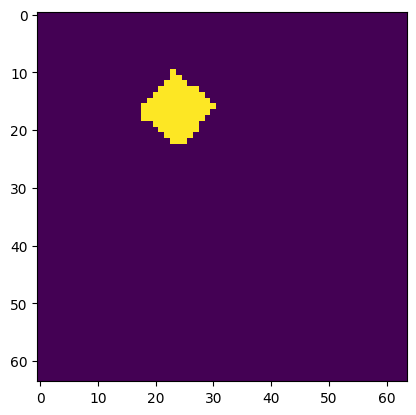

In [39]:
model = get_model_down(factors[1],l_thresholds[0],h_thresholds[0])
train_loader = get_dataloaders("dsprites",dims[1],l_thresholds[0],h_thresholds[0],
                                       batch_size=1024,logger=logger)
print(train_loader.dataset.__len__())
shape_lim=32*32*40*6
reference_shape = 3 #square
np.random.seed(2)
imgs,lats=train_loader.dataset.imgs, train_loader.dataset.lat_values
train_loader = get_dataloaders("dsprites",dims[1],l_thresholds[0],h_thresholds[0],
                                       batch_size=1024,logger=logger)
img,l = train_loader.dataset.__getitem__(9000)
dataset_dsprites=train_loader.dataset
print(l)
plt.imshow(img.permute(2,1,0))
data=img


## Linearity on dSprites

In [40]:
dataset = get_dataloaders("dsprites").dataset

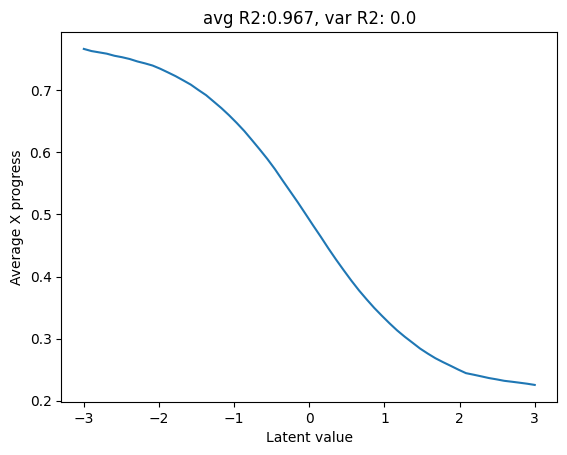

In [41]:
model=get_model(rate=1,z=6)
lower_bound = -3
upper_bound = 3
code_sample_size = 60
dim = 0 #latent dimension 
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
r2_scores=[]
mae_scores=[]
x_p=[]
n=100 #n runs
img_samples = [dataset.__getitem__(ind)[0] for ind in np.random.choice(dataset.__len__(),n)]
#use plot=True and reduce code_samples_size to plot the traversing resutlts 
for i in range(n):
    images = traverse_latent(img_samples[i], device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=False)
    _,centers = get_centers_mov(images)
    x_progress = [i[0]/64 for i in centers]
    res = stats.linregress(traversals, x_progress)
    x_p.append(x_progress)
    r2_scores.append(round(res.rvalue**2,3))
avg_r2=round(sum(r2_scores)/len(r2_scores),3)
var_r2=np.round(np.var(r2_scores),4)
x_p=np.array(x_p).mean(axis=0)
plt.plot(traversals,x_p)
plt.xlabel("Latent value")
plt.ylabel("Average X progress")
plt.title("avg R2:{}, var R2: {}".format(avg_r2,var_r2))
plt.savefig("linearity_posx_dsprites.png")
plt.savefig("posx_prog_dspr.png")

plt.show()

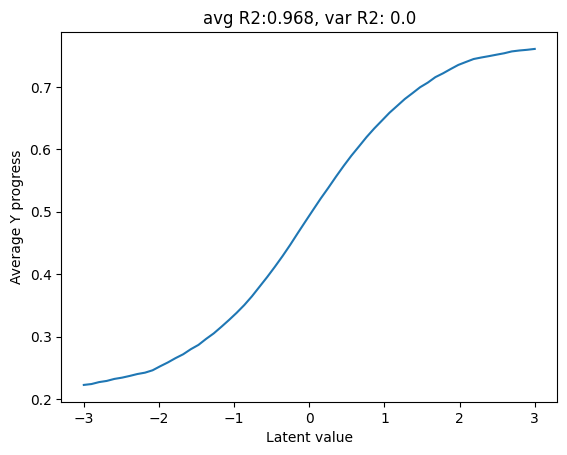

In [42]:
model=get_model(rate=1,z=8)

lower_bound = -3
upper_bound = 3
code_sample_size = 60
dim = 3 #latent_dimension
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
r2_scores=[]
mae_scores=[]
x_p=[]
n=100
img_samples = [dataset.__getitem__(ind)[0] for ind in np.random.choice(dataset.__len__(),n)]
for i in range(n):
    images = traverse_latent(img_samples[i], device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=False)
    _,centers = get_centers_mov(images)
    x_progress = [i[1]/64 for i in centers]
    res = stats.linregress(traversals, x_progress)
    x_p.append(x_progress)
    r2_scores.append(round(res.rvalue**2,3))
avg_r2=round(sum(r2_scores)/len(r2_scores),3)
var_r2=np.round(np.var(r2_scores),5)
x_p=np.array(x_p).mean(axis=0)
plt.plot(traversals,x_p)
plt.xlabel("Latent value")
plt.ylabel("Average Y progress")
plt.title("avg R2:{}, var R2: {}".format(avg_r2,var_r2))
plt.savefig("linearity_posx_dsprites.png")
plt.savefig("posy_prog_dspr.png")

plt.show()

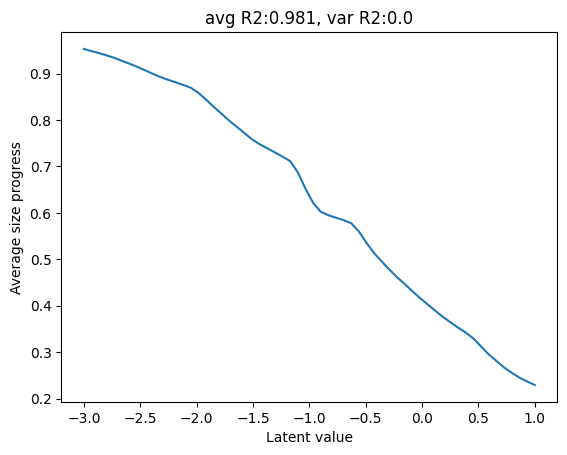

In [43]:
lower_bound = -3
upper_bound = 1
code_sample_size = 60
dim = 7
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
r2_scores=[]
mae_scores=[]
x_p=[]
n=100
img_samples = [dataset.__getitem__(ind)[0] for ind in np.random.choice(dataset.__len__(),n)]
for i in range(n):
    images = traverse_latent(img_samples[i], device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=False)
    x_progress = get_surface_mov(images)[1]
    x_progress = [e*10 for e in x_progress]
    res = stats.linregress(traversals, x_progress)
    x_p.append(x_progress)
    r2=round(res.rvalue**2,3)
    #print(r2)
    r2_scores.append(r2)
avg_r2=round(sum(r2_scores)/len(r2_scores),3)
var_r2=np.round(np.var(r2_scores),4)
x_p=np.array(x_p).mean(axis=0)
plt.plot(traversals,x_p)
plt.xlabel("Latent value")
plt.ylabel("Average size progress")
plt.title("avg R2:{}, var R2:{}".format(avg_r2,var_r2))
plt.savefig("scale_prog_dspr.png")
plt.show()

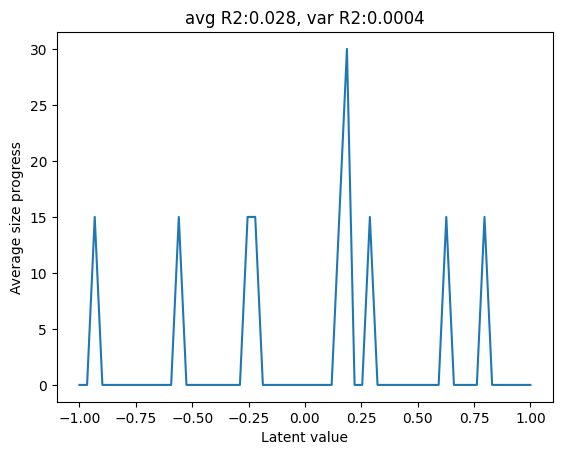

In [44]:
model=get_model(rate=1,z=8)

lower_bound = -1
upper_bound = 1
code_sample_size = 60
dim=0
n_samples=3
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
r2_scores=[]
x_p=[]
samples_idx = [128000, 281600, 435200]
all_angles=[]
samples = [dataset.__getitem__(idx)[0] for idx in samples_idx]
for data in samples:    
    images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=False)
    angles=get_angles_mov(images)
    angles.insert(0,0)
    res = stats.linregress(traversals, angles)
    all_angles.append(angles)
    r2=round(res.rvalue**2,3)

    r2_scores.append(r2)
avg_r2=round(sum(r2_scores)/len(r2_scores),3)
var_r2=np.round(np.var(r2_scores),4)
x_p=np.array(all_angles).mean(axis=0)
plt.plot(traversals,x_p)
plt.xlabel("Latent value")
plt.ylabel("Average size progress")
plt.title("avg R2:{}, var R2:{}".format(avg_r2,var_r2))
plt.savefig("angle_prog.png")
plt.show()

In [56]:

%load_ext autoreload

%autoreload 2
def compute_dcimig(mus_train, ys_train,gen_dim=None):
    Im = continuous_mutual_info(mus_train, ys_train)
    n_codes,n_factors=Im.shape[0],Im.shape[1]
    Dis_codes=[0 for i in range(n_codes)]
    gen_per_code = [-1 for i in range(n_codes)]
    code_per_gen = [-1 for i in range(n_factors)]
    Dis_code_z=[0 for i in range(n_factors)]
    for ci in range(n_codes):
        z_j_ci = np.argmax(Im[ci,:])
        gen_per_code[ci] = z_j_ci
        sorted_Im_ci = np.sort(Im[ci])[::-1]
        Dis_codes[ci] = sorted_Im_ci[0] - sorted_Im_ci[1]
    for z_j in range(n_factors):
        if z_j not in gen_per_code:
            Dis_code_z[z_j]=0
        else:
            codes=[c for c in range(n_codes) if gen_per_code[c]==z_j]
            m=0
            best_code=-1
            for code in codes:
                if m<Dis_codes[code]:
                    best_code=code
                    m=Dis_codes[code]
            Dis_code_z[z_j]=Dis_codes[best_code]
            code_per_gen[z_j]=best_code
    #Dis_code_z=Dis_code_z[1:]       
    entropy = continous_entropy(ys_train)
    if gen_dim:
        return {"DCIMIG":Dis_code_z[gen_dim]/entropy[gen_dim]}
    
    return {"DCIMIG":np.sum(Dis_code_z)/np.sum(entropy)}
def metric_dci(
        mus_train,
        ys_train,
        mus_test,
        ys_test,
        n_codes,
        only_Im=False,
        num_train: int = 10000,
        num_test: int = 5000,
        batch_size: int = 16,
        boost_mode='sklearn',
        show_progress=False,
        
):



    #print("Computing DCI metric with latent codes".format(n_codes))
    scores = _compute_dci(mus_train, ys_train, mus_test, ys_test,only_Im, boost_mode=boost_mode, show_progress=False)
    if only_Im:
        return {"0":scores}
    return scores


def _compute_dci(mus_train, ys_train, mus_test, ys_test,only_Im, boost_mode='sklearn', show_progress=True):
    """Computes score based on both training and testing codes and factors."""
    importance_matrix, train_err, test_err = _compute_importance_gbt(mus_train, ys_train, mus_test, ys_test, boost_mode=boost_mode, show_progress=show_progress)
    if only_Im:
        return importance_matrix
    assert importance_matrix.shape[0] == mus_train.shape[0]
    assert importance_matrix.shape[1] == ys_train.shape[0]
    return {
        "dci.inf_train": train_err,                      # "dci.explicitness" -- Measuring Disentanglement: A Review of Metrics
        "dci.inf_test": test_err,                        # "dci.explicitness" -- Measuring Disentanglement: A Review of Metrics
        "dci.dis": _disentanglement(importance_matrix),  # "dci.modularity"   -- Measuring Disentanglement: A Review of Metrics
        "dci.comp": _completeness(importance_matrix),        # "dci.compactness"  -- Measuring Disentanglement: A Review of Metrics
       "importance_matrix" : importance_matrix,
        "dci.dis_per_code":_disentanglement_per_code(importance_matrix),
        "dci.completeness_per_factor" : _completeness_per_factor(importance_matrix)
    }

def continous_entropy(ys):
    """
    Compute discrete mutual information.
    """
    num_factors = ys.shape[0]
    h = np.zeros(num_factors)
    for j in range(num_factors):
        h[j] = entropy(ys[j, :])
    return h
def _compute_importance_gbt(x_train, y_train, x_test, y_test, boost_mode='xgboost', show_progress=False):
    """Compute importance based on gradient boosted trees."""
    num_factors = y_train.shape[0]
    num_codes = x_train.shape[0]
    importance_matrix = np.zeros(shape=[num_codes, num_factors], dtype=np.float64)
    train_loss = []
    test_loss = []
    for i in tqdm(range(num_factors), disable=(not show_progress)):
        if boost_mode == 'sklearn':
            from sklearn.ensemble import GradientBoostingRegressor
            model = GradientBoostingRegressor()
        elif boost_mode == 'xgboost':
            from xgboost import XGBRegressor
            model = XGBRegressor(tree_method='gpu_hist', gpu_id=7)
        elif boost_mode == 'lightgbm':
            from lightgbm import LGBMRegressor
            model = LGBMRegressor()
        else:
            raise KeyError(f'Invalid boosting mode: {boost_mode=}')
        model.fit(x_train.T, y_train[i, :])
        importance_matrix[:, i] = np.abs(model.feature_importances_)
        train_loss.append(np.mean(abs(model.predict(x_train.T) - y_train[i, :])))
        test_loss.append(np.mean(abs(model.predict(x_test.T) - y_test[i, :])))
    return importance_matrix, 1/np.mean(train_loss), 1/np.mean(test_loss)


def _disentanglement_per_code(importance_matrix):
    """Compute disentanglement score of each code."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix.T + 1e-11, base=importance_matrix.shape[1])


def _disentanglement(importance_matrix):
    """Compute the disentanglement score of the representation."""
    per_code = _disentanglement_per_code(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()
    return np.sum(per_code * code_importance)


def _completeness_per_factor(importance_matrix):
    """Compute completeness of each factor."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix + 1e-11, base=importance_matrix.shape[0])


def _completeness(importance_matrix):
    """"Compute completeness of the representation."""
    per_factor = _completeness_per_factor(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    factor_importance = importance_matrix.sum(axis=0) / importance_matrix.sum()
    return np.sum(per_factor * factor_importance)


def continuous_mutual_info(mus, ys):
    """
    Compute discrete mutual information.
    """
    num_codes = mus.shape[0]
    num_factors = ys.shape[0]
    m = np.zeros([num_codes, num_factors])
    for i in range(num_codes):
        for j in range(num_factors):
            m[i, j] = mutual_info_regression(ys[j, :].reshape(-1,1), mus[i, :])
    return m



def compute_mig(mus_train, ys_train,gen_dim=None):
    """
    Computes score based on both training and testing codes and factors.
    """
    #discretized_mus = utils.histogram_discretize(mus_train, num_bins=20)
    m = continuous_mutual_info(mus_train, ys_train)
    assert m.shape[0] == mus_train.shape[0]
    assert m.shape[1] == ys_train.shape[0]
    #m = m[:,1:]
    # m is [num_latents, num_factors]
    entropy = continous_entropy(ys_train)    #entropy = utils.discrete_entropy(ys_train)
    nrom_diff=[0 for i in range(m.shape[1])]
        
    if gen_dim:
        sorted_m = np.sort(m[gen_dim,:], axis=0)[::-1]
        return {
        "mig.discrete_score": (sorted_m[0] - sorted_m[1])/entropy[gen_dim] # "modularity: MIG" -- Measuring Disentanglement: A Review of Metrics
    }
    else:
        sorted_m = np.sort(m, axis=0)[::-1]
    #print(entropy)
    #print(entropy.shape)
    #print(sorted_m.shape)
    #residuals=sorted_m[0, :] - sorted_m[1, :]
    #print(residuals.shape)
    return {
        "MIG": np.mean(np.divide(sorted_m[0, :] - sorted_m[1, :], entropy[:]))  # "modularity: MIG" -- Measuring Disentanglement: A Review of Metrics
    }



def evaluate_metrics(ds,model,rate,dimension=None,num_train=2000,num_test=500):
    rate=1
    transforms_ds = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
    d_res=[]
    model.eval()
    train_imgs_indices = random.sample(range(0, ds.__len__()),num_train)
    train_imgs = [ds.__getitem__(ind)[0] for ind in train_imgs_indices]
    mus_train = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in train_imgs])
    mus_train = np.squeeze(mus_train,axis=1).T
    train_labels = np.array([ds.__getitem__(ind)[1] for ind in train_imgs_indices]).T
    test_imgs_indices = random.sample(range(0, ds.__len__()),num_test)
    test_imgs = [ds.__getitem__(ind)[0] for ind in test_imgs_indices]
    mus_test = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in test_imgs])
    mus_test = np.squeeze(mus_test,axis=1).T
    test_labels = np.array([ds.__getitem__(ind)[1] for ind in test_imgs_indices]).T
    print("Computing MIG metric")
    print("Computing DCI metrics")
    d=metric_dci(mus_train,train_labels,mus_test,test_labels,n_codes=model.latent_dim,boost_mode="xgboost")
    print("Computing DCIMIG metric")
    d.update(compute_dcimig(mus_train,train_labels,gen_dim=dimension))
    d.update(compute_mig(mus_train,train_labels,gen_dim=dimension))
    return d 
ds = get_dataloaders("dsprites").dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dimension: 0


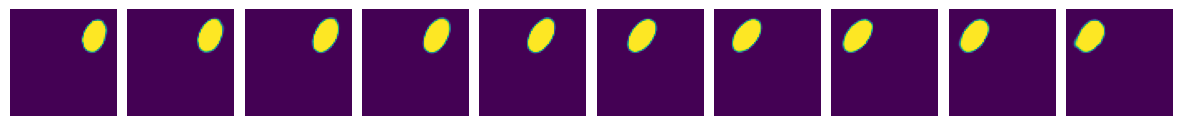

Computing MIG metric
Computing DCI metrics
Computing DCIMIG metric
DCIMIG: 0.3451747293958874, Disentanglment: 0.8030849039310286
Dimension: 1


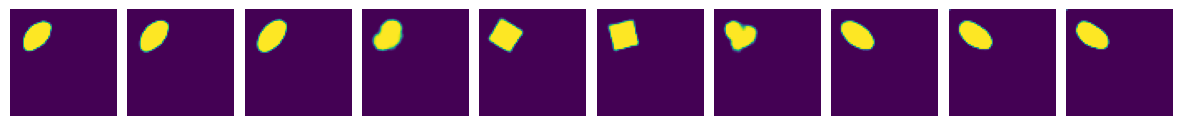

Computing MIG metric
Computing DCI metrics
Computing DCIMIG metric
DCIMIG: 0.09622833672800071, Disentanglment: 0.42958558948657743
Dimension: 2


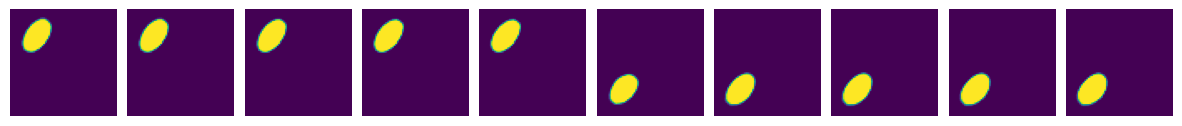

Computing MIG metric
Computing DCI metrics
Computing DCIMIG metric
DCIMIG: 0.2813754785030709, Disentanglment: 0.7067107589896493
Dimension: 3


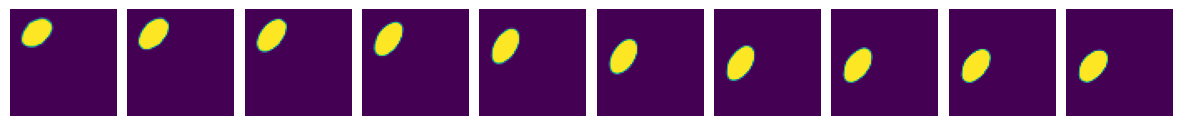

Computing MIG metric
Computing DCI metrics
Computing DCIMIG metric
DCIMIG: 0.2754616887774247, Disentanglment: 0.552925793777095
Dimension: 4


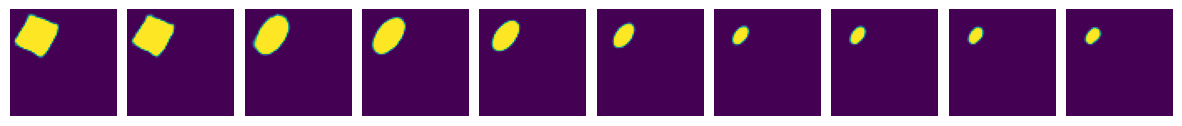

Computing MIG metric
Computing DCI metrics
Computing DCIMIG metric
DCIMIG: 0.09329323489540199, Disentanglment: 0.47139347764224315
Dimension: 5


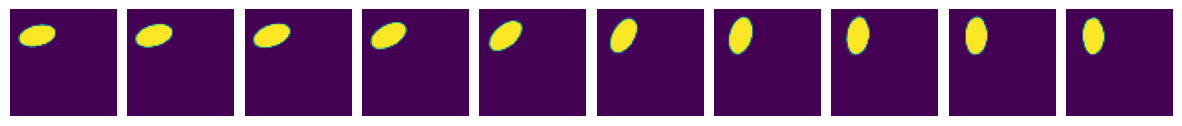

Computing MIG metric
Computing DCI metrics
Computing DCIMIG metric
DCIMIG: 0.08978546252011527, Disentanglment: 0.4329301055759762


In [57]:
model=get_model(rate=1,z=6)
lower_bound=-4
upper_bound=4
true_dimensions=[3,2,4,4,1,2]
code_sample_size=10
dcimig,modularity,completness,info=[],[],[],[]
for d in range(model.latent_dim):
    print("Dimension: {}".format(d))
    images = traverse_latent(data, device, model, d, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size)
    dcimig_dim = evaluate_metrics(ds,model,rate=1,dimension=true_dimensions[d])
    dcimig.append(dcimig_dim["DCIMIG"])
    modularity.append(dcimig_dim["dci.dis_per_code"][d])
    info.append(dcimig_dim['dci.inf_test'])
    completness.append(dcimig_dim["dci.completeness_per_factor"][true_dimensions[d]])
    print("DCIMIG: {}, Disentanglment: {}".format(dcimig_dim["DCIMIG"],dcimig_dim["dci.dis_per_code"][d]))
dim_names=["posX","ang + shape","posY","posY","scale","ang + shape"]
linearity=["linear","non-linear","linear","linear","linear","non-linear"]
df=pd.DataFrame()
df['modularity']=modularity
df["DCIMIG"]=dcimig
df["linearity"]=linearity
df["gen_factor"]=dim_names
df["completness"]=completness


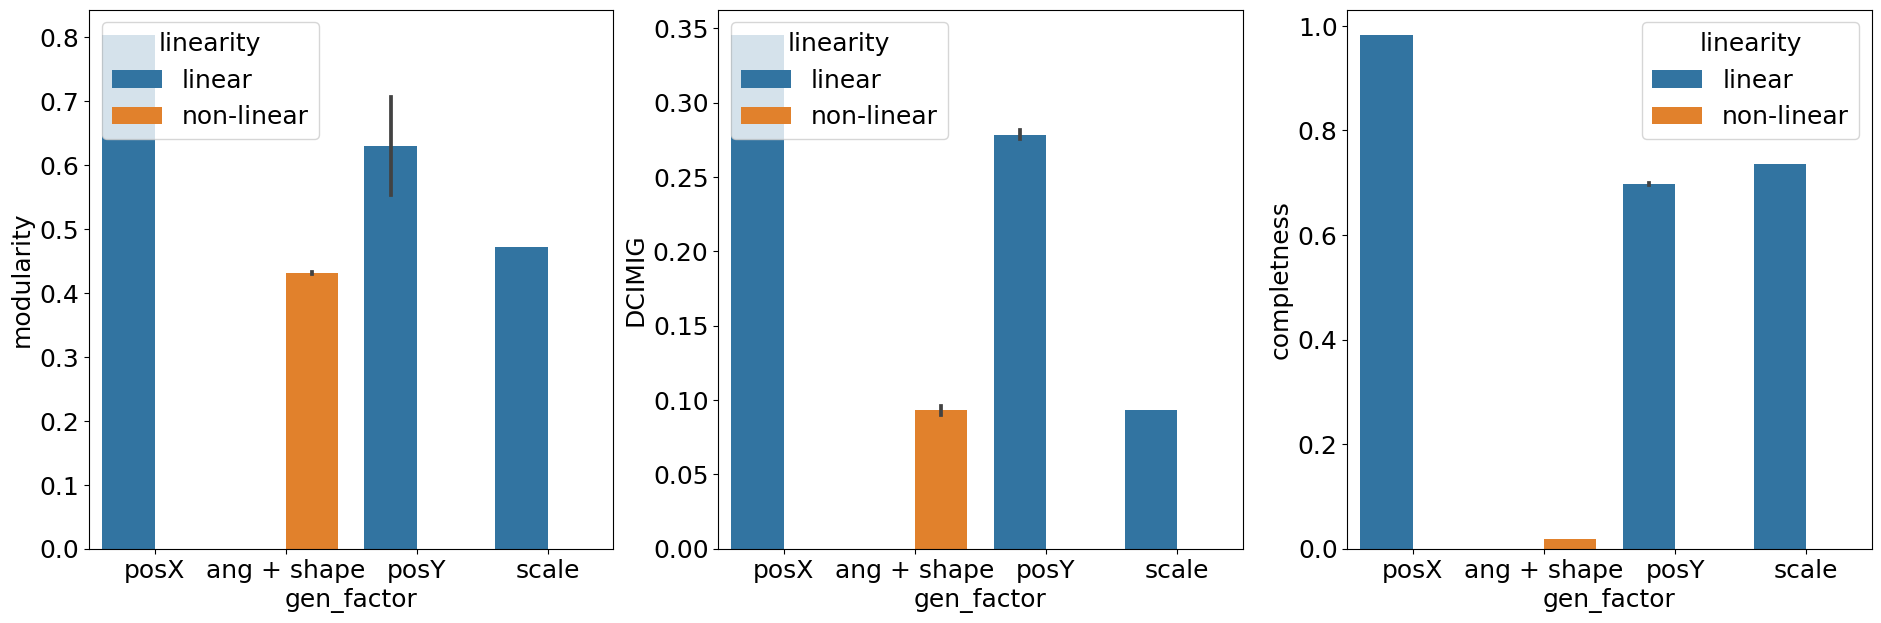

In [58]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(1,3,figsize=(23,7))
sns.barplot(data=df,x="gen_factor",y="modularity",hue="linearity",ax=ax[0])
#ax[0].tick_params(axis='x', rotation=45)
sns.barplot(data=df,x="gen_factor",y="DCIMIG",hue="linearity",ax=ax[1])
#ax[1].tick_params(axis='x', rotation=45)
sns.barplot(data=df,x="gen_factor",y="completness",hue="linearity",ax=ax[2])
#ax[2].tick_params(axis='x', rotation=45)
plt.savefig("linearity_effect_dspr.png")
plt.show()

# Linearity on MNIST

In [24]:
def load_model_mnist(n_latent):
    device = torch.device('cuda:{}'.format(2))
    model_dir = "/root/Soufien/disvae/my_results/btcvae_mnist_enriched_0_3_{}/model.pt"
    model = init_specific_model("Burgess", (1,32,32), n_latent)
    model.load_state_dict(torch.load(model_dir.format(n_latent)))
    model = model.to(device)
    return model
ds_mnist = MNIST("data/MNIST_0_3_enrch")

t_dl = DataLoader(ds_mnist,batch_size=1)

/root/anaconda3/envs/disvae/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/disvae/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/root/anaconda3/envs/disvae/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


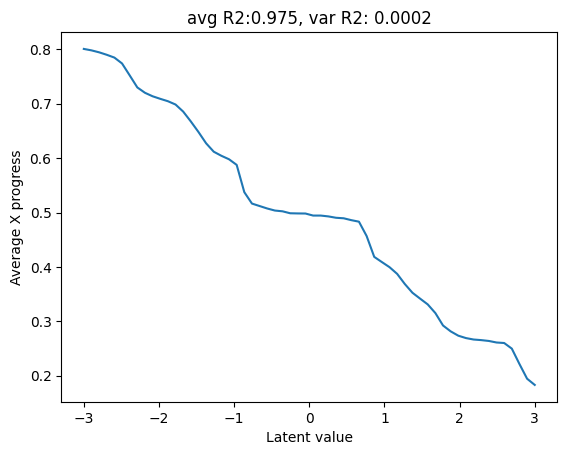

In [25]:
model=load_model_mnist(6)
lower_bound = -3
upper_bound = 3

code_sample_size = 60
dim = 0
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
#images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=4)
r2_scores=[]
mae_scores=[]
x_p=[]
n=100
img_samples = [ds_mnist.__getitem__(ind)[0] for ind in np.random.choice(ds_mnist.__len__(),n)]
for i in range(n):
    images = traverse_latent(img_samples[i], device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=False)
    _,centers = get_centers_mov(images)
    x_progress = [i[0]/32 for i in centers]
    x_p.append(x_progress)
    res = stats.linregress(traversals, x_progress)
    r2_scores.append(round(res.rvalue**2,3))
avg_r2=round(sum(r2_scores)/len(r2_scores),3)
var_r2=np.round(np.var(r2_scores),4)
avg_mae=round(sum(mae_scores)/len(r2_scores),3)
var_mae=np.round(np.var(mae_scores),4)
x_p=np.array(x_p).mean(axis=0)
plt.plot(traversals,x_p)
plt.xlabel("Latent value")
plt.ylabel("Average X progress")
plt.title("avg R2:{}, var R2: {}".format(avg_r2,var_r2))
plt.savefig("linearity_posx_mnist.png")
plt.show()

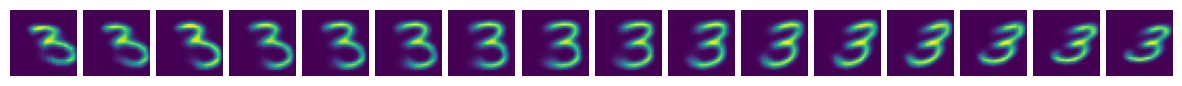

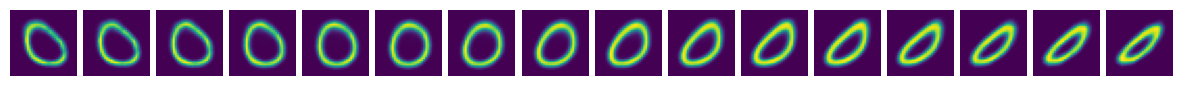

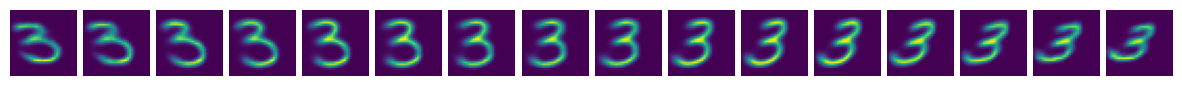

In [26]:
model=load_model_mnist(6)
lower_bound = -3
upper_bound = 3

code_sample_size = 16
dim = 3
n_samples=3
samples_idx = np.random.choice(range(0,ds_mnist.__len__()),n_samples) 
samples = [ds_mnist.__getitem__(idx)[0] for idx in samples_idx]
all_imgs=[]
for data in samples:
    images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=True)
    

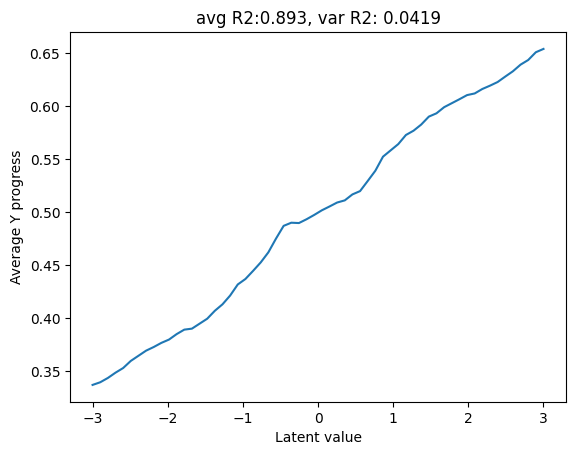

In [27]:
lower_bound = -3
upper_bound = 3

code_sample_size = 60
dim = 4
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
#images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=4)
r2_scores=[]
mae_scores=[]
x_p=[]
n=100
img_samples = [ds_mnist.__getitem__(ind)[0] for ind in np.random.choice(ds_mnist.__len__(),n)]
for i in range(n):
    images = traverse_latent(img_samples[i], device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=False)
    _,centers = get_centers_mov(images)
    x_progress = [i[1]/32 for i in centers]
    x_p.append(x_progress)
    res = stats.linregress(traversals, x_progress)
    r2_scores.append(round(res.rvalue**2,3))
avg_r2=round(sum(r2_scores)/len(r2_scores),3)
var_r2=np.round(np.var(r2_scores),4)
avg_mae=round(sum(mae_scores)/len(r2_scores),3)
var_mae=np.round(np.var(mae_scores),4)
x_p=np.array(x_p).mean(axis=0)
plt.plot(traversals,x_p)
plt.xlabel("Latent value")
plt.ylabel("Average Y progress")
plt.title("avg R2:{}, var R2: {}".format(avg_r2,var_r2))
plt.savefig("linearity_posy_mnist.png")
plt.show()

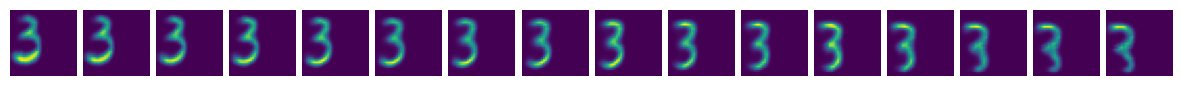

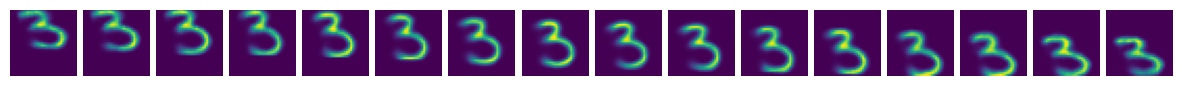

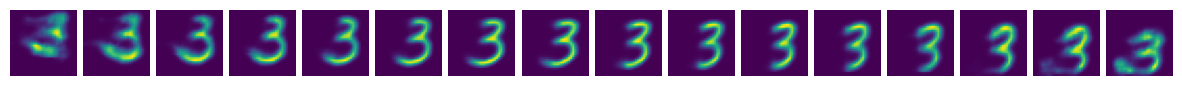

In [28]:
model=load_model_mnist(6)
lower_bound = -3
upper_bound = 3

code_sample_size = 16
dim = 4
n_samples=3
samples_idx = np.random.choice(range(0,ds_mnist.__len__()),n_samples) 
samples = [ds_mnist.__getitem__(idx)[0] for idx in samples_idx]
all_imgs=[]
for data in samples:
    images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=True)
    

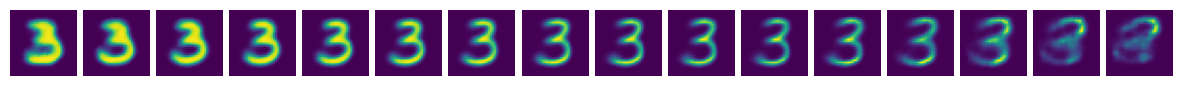

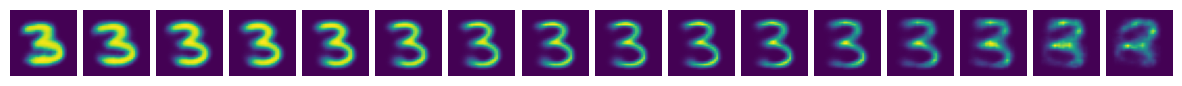

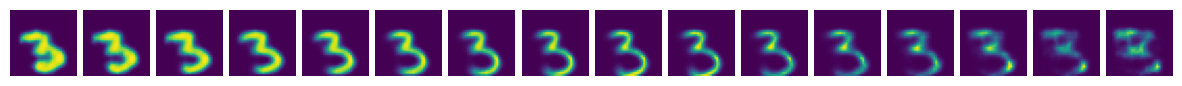

In [29]:
model=load_model_mnist(6)
lower_bound = -4
upper_bound = 4

code_sample_size = 16
dim = 2
n_samples=3
samples_idx = np.random.choice(range(0,ds_mnist.__len__()),n_samples) 
samples = [ds_mnist.__getitem__(idx)[0] for idx in samples_idx]
all_imgs=[]
for data in samples:
    images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=True)
    

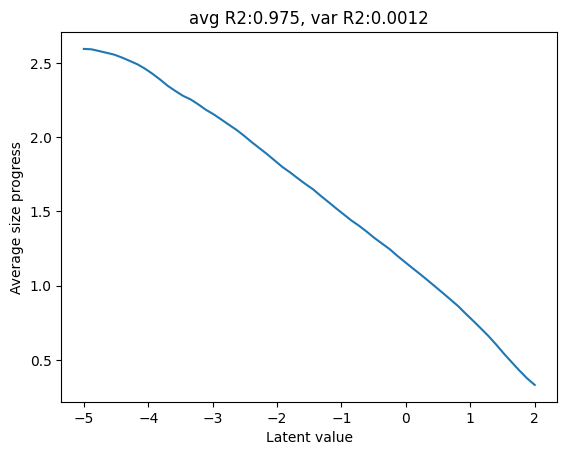

In [30]:
lower_bound = -5
upper_bound = 2

code_sample_size = 60
dim = 2
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
#images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=4)
r2_scores=[]
mae_scores=[]
x_p=[]
n=100
img_samples = [ds_mnist.__getitem__(ind)[0] for ind in np.random.choice(ds_mnist.__len__(),n)]
for i in range(n):
    images = traverse_latent(img_samples[i], device, model, dim, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=False)
    x_progress = get_surface_mov(images)[1]
    x_progress = [e*10 for e in x_progress]
    res = stats.linregress(traversals, x_progress)
    x_p.append(x_progress)
    r2=round(res.rvalue**2,3)
    #print(r2)
    r2_scores.append(r2)
avg_r2=round(sum(r2_scores)/len(r2_scores),3)
var_r2=np.round(np.var(r2_scores),4)
x_p=np.array(x_p).mean(axis=0)
plt.plot(traversals,x_p)
plt.xlabel("Latent value")
plt.ylabel("Average size progress")
plt.title("avg R2:{}, var R2:{}".format(avg_r2,var_r2))
plt.savefig("linearity_thickness_mnist.png")

plt.show()